# Петрик і вовк: реалістичне середовище

У нашій ситуації Петрик міг пересуватися майже без втоми чи голоду. У більш реалістичному світі йому доводиться час від часу сідати і відпочивати, а також годувати себе. Давайте зробимо наш світ більш реалістичним, впровадивши наступні правила:

1. Пересуваючись з одного місця в інше, Петрик втрачає **енергію** і набирає **втому**.
2. Петрик може отримати більше енергії, з'ївши яблука.
3. Петрик може позбутися втоми, відпочиваючи під деревом або на траві (тобто заходячи на клітинку дошки з деревом або травою - зелене поле).
4. Петрик має знайти і вбити вовка.
5. Для того, щоб убити вовка, Петрик повинен мати певний рівень енергії та втоми, інакше він програє битву.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from rlboard import *

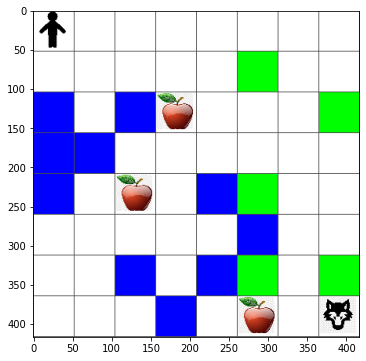

In [2]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

In [3]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

## Визначення стану

У наших нових правилах гри нам потрібно відстежувати енергію та втому на кожному стані дошки. Тому ми створимо об'єкт `state`, який буде містити всю необхідну інформацію про поточний стан задачі, включаючи стан дошки, поточні рівні енергії та втоми, а також чи можемо ми перемогти вовка в кінцевому стані:


In [4]:
class state:
    def __init__(self,board,energy=10,fatigue=0,init=True):
        self.board = board
        self.energy = energy
        self.fatigue = fatigue
        self.dead = False
        if init:
            self.board.random_start()
        self.update()

    def at(self):
        return self.board.at()

    def update(self):
        if self.at() == Board.Cell.water:
            self.dead = True
            return
        if self.at() == Board.Cell.tree:
            self.fatigue = 0
        if self.at() == Board.Cell.apple:
            self.energy = 10

    def move(self,a):
        self.board.move(a)
        self.energy -= 1
        self.fatigue += 1
        self.update()

    def is_winning(self):
        return self.energy > self.fatigue

In [5]:
def random_policy(state):
    return random.choice(list(actions))

def walk(board,policy):
    n = 0 # number of steps
    s = state(board)
    while True:
        if s.at() == Board.Cell.wolf:
            if s.is_winning():
                return n # success!
            else:
                return -n # failure!
        if s.at() == Board.Cell.water:
            return 0 # died
        a = actions[policy(m)]
        s.move(a)
        n+=1

walk(m,random_policy)

0

In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        elif z==0:
            n+=1
        else:
            s+=1
    print(f"Killed by wolf = {w}, won: {s} times, drown: {n} times")

print_statistics(random_policy)

Killed by wolf = 5, won: 1 times, drown: 94 times


## Функція винагороди

Функція винагороди є ключовим компонентом у навчанні з підкріпленням. Вона визначає, як агент оцінює свої дії, і спрямовує його до досягнення бажаної мети.

### Основні принципи

1. **Чіткість і простота**  
   Функція винагороди повинна бути якомога простішою, щоб уникнути непередбачуваної поведінки агента. Складні функції можуть призвести до небажаних результатів.

2. **Стимулювання бажаної поведінки**  
   Винагороди повинні мотивувати агента виконувати дії, які сприяють досягненню мети. Наприклад, якщо мета — зменшити витрати, агент повинен отримувати винагороду за дії, які знижують витрати.

3. **Уникнення негативних наслідків**  
   Важливо враховувати можливі побічні ефекти. Неправильно налаштована функція винагороди може призвести до того, що агент знайде небажані "шпарини" у системі.

### Приклад функції винагороди

```python
def reward_function(state, action):
    if action == "desired_action":
        return 10  # Винагорода за бажану дію
    elif action == "neutral_action":
        return 0  # Нейтральна дія, без винагороди
    else:
        return -10  # Штраф за небажану дію
```

### Поради щодо налаштування

- **Тестуйте функцію винагороди**  
  Переконайтеся, що функція винагороди працює належним чином у різних сценаріях. Це допоможе виявити потенційні проблеми.

- **Уникайте надмірного покарання**  
  Надмірні штрафи можуть призвести до того, що агент уникатиме ризиків, навіть якщо це необхідно для досягнення мети.

- **Враховуйте довгострокові наслідки**  
  Агент повинен розуміти, що короткострокові винагороди можуть бути менш важливими, ніж довгострокові вигоди.

### Висновок

Функція винагороди є основою для навчання агента. Її правильне налаштування забезпечує ефективне досягнення мети та мінімізує ризики небажаної поведінки.


In [7]:
def reward(s):
    r = s.energy-s.fatigue
    if s.at()==Board.Cell.wolf:
        return 100 if s.is_winning() else -100
    if s.at()==Board.Cell.water:
        return -100
    return r

## Алгоритм Q-навчання

Сам алгоритм навчання залишається майже незмінним, ми просто використовуємо `state` замість лише позиції на дошці.


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

In [9]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [10]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    s = state(m)
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = s.board.human
        v = probs(Q[x,y])
        while True:
            a = random.choices(list(actions),weights=v)[0]
            dpos = actions[a]
            if s.board.is_valid(s.board.move_pos(s.board.human,dpos)):
                break 
        s.move(dpos)
        r = reward(s)
        if abs(r)==100: # end of game
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

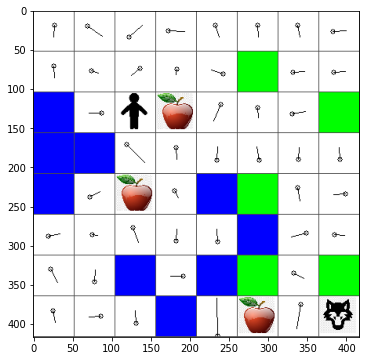

In [11]:
m.plot(Q)

## Результати

Давайте подивимось, чи вдалося нам навчити Петра боротися з вовком!


In [12]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Killed by wolf = 1, won: 9 times, drown: 90 times


Ми тепер бачимо набагато менше випадків утоплення, але Пітер все ще не завжди може вбити вовка. Спробуйте експериментувати та подивіться, чи зможете ви покращити цей результат, змінюючи гіперпараметри.


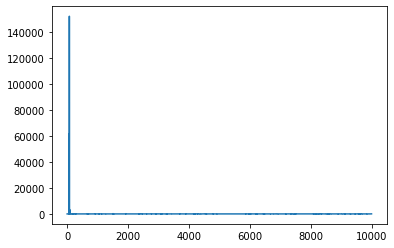

In [13]:
plt.plot(lpath)


---

**Відмова від відповідальності**:  
Цей документ було перекладено за допомогою сервісу автоматичного перекладу [Co-op Translator](https://github.com/Azure/co-op-translator). Хоча ми прагнемо до точності, зверніть увагу, що автоматичні переклади можуть містити помилки або неточності. Оригінальний документ мовою оригіналу слід вважати авторитетним джерелом. Для критично важливої інформації рекомендується професійний людський переклад. Ми не несемо відповідальності за будь-які непорозуміння або неправильні тлумачення, що виникли внаслідок використання цього перекладу.
